In [25]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from skimage.transform import resize

from pydmd import DMD

os.sys.path.append("../") # need to add modules to path

# local imports
from prepare import prepare
from file_io import czi_reader
from file_io import ome_writer
from utils import tools
from segment import cell_detector

In [2]:
"""
Load test data
"""

# test image
TEST_PATH = "../../Data/test/3x3-extract-Scene6-07-14to15.czi"

# czi file loader
czi = czi_reader.CZILoader(TEST_PATH)

# cleaned scene
czi.restructure_scene(scene=0)
scene = czi.scene
print(scene.shape)


(49, 9, 472, 640, 4)


In [3]:
"""
process the blue channel
"""

CHANNEL = 2

# cheap processing
processed_scene = scene.copy()

for tile in range(9):
    for i in range(49):
        processed_scene[i, tile, :, :, CHANNEL] = prepare.transform(processed_scene[i, tile, :, :, CHANNEL], binarize=True)

print(processed_scene.shape)

(49, 9, 472, 640, 4)


In [4]:
"""
stitch the mosiac
"""

blocker = tools.SceneBlocker(processed_scene)
blocked_scene_p = blocker.block()

tensor = blocked_scene_p[:, :, :, 2]

print(tensor.shape)

(49, 1416, 1920)


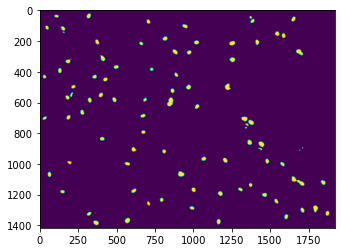

In [5]:
plt.imshow(tensor[0,:, :])

In [35]:
# convert the data into something useable by PyDMD

FACTOR = 10

img_size = (tensor[0].shape[0] // FACTOR, tensor[0].shape[1] // FACTOR)
X = np.zeros((49, img_size[0] * img_size[1]))

for t in range(len(tensor)):
    img = tensor[t, :, :]
    img = resize(img, img_size, anti_aliasing=True)
    img = img.flatten()
    X[t] = img

print(X.shape)

(49, 27072)


In [36]:
dmd = DMD(svd_rank=2)
dmd.fit(X.T)

Eigenvalue (0.9922510936752376+0.03146028554189759j): distance from unit circle 0.014448017533917223
Eigenvalue (0.9922510936752376-0.03146028554189759j): distance from unit circle 0.014448017533917223


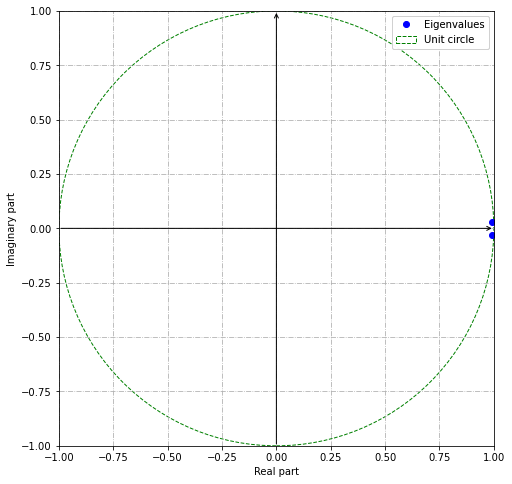

In [37]:
for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

In [39]:
# for mode in dmd.modes.T:
#     plt.plot(x, mode.real)
#     plt.title('Modes')
# plt.show()

# for dynamic in dmd.dynamics:
#     plt.plot(t, dynamic.real)
#     plt.title('Dynamics')
# plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pydmd/dmdbase.py:329: UserWarning: Input data matrix X has condition number inf. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  .format(cond_number))
Eigenvalue (0.9995767046870103+0.001968518629982034j): distance from unit circle 0.0008425363814607012
Eigenvalue (0.9995767046870103-0.001968518629982034j): distance from unit circle 0.0008425363814607012


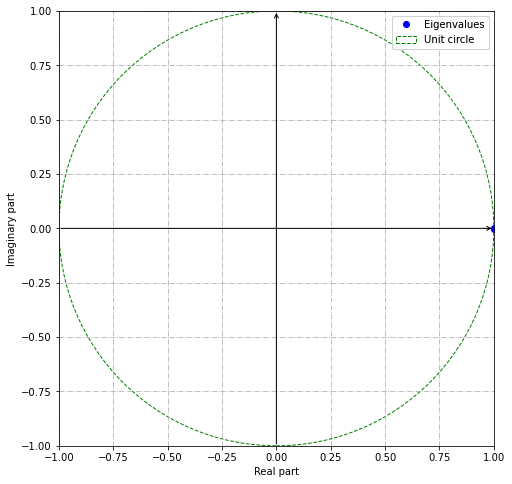

In [43]:
dmd = DMD(svd_rank=2)
dmd.fit(tensor.T)

for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

In [48]:
tensor.shape

(49, 1416, 1920)

In [47]:
dmd.modes.shape

(69384, 2)

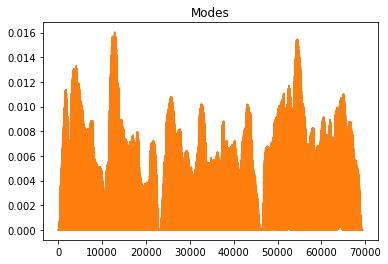

In [50]:
for mode in dmd.modes.T:
    plt.plot(mode.real)
    plt.title('Modes')
plt.show()

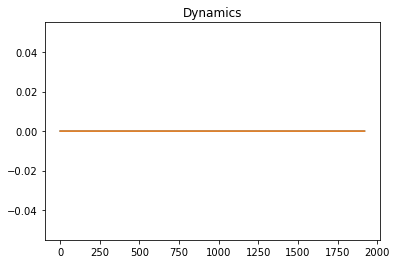

In [51]:
for dynamic in dmd.dynamics:
    plt.plot(dynamic.real)
    plt.title('Dynamics')
plt.show()